In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#########################
#  1) Convert function  #
#########################
def convert_int_to_symbol(ls):
    """
    Convert, for example, 
    ['*', 'O', 'C', 'H', '3'] 
    to
    ['*', 'O', 'C', 'H', 'H', 'H']
    """
    try:
        parenthesis_left = ls.index('(')
        parenthesis_right = ls.index(')')
        len_par = parenthesis_right - parenthesis_left - 1
    except:
        pass
        
    converted_ls = []
    for i in range(len(ls)):
        try:
            multiple = int(ls[i]) - 1
            insert_elem = ls[i-1]
            if insert_elem != ')':
                for _ in range(multiple):
                    converted_ls.append(insert_elem)
            else:
                # if there's something like (OH)2
                insert_elems = converted_ls[parenthesis_left:parenthesis_left+len_par]
                for j in range(multiple):
                    for k in range(len(insert_elems)):
                        converted_ls.append(insert_elems[k])
        except:
            if ls[i] != '(' and ls[i] != ')':
                converted_ls.append(ls[i])
            
    _ls = [x for x in converted_ls if x != '-']
    result_list = [x for x in _ls if x != '*']

    return result_list


#################################
#  2) Make Reaction (with H#)   #
#################################
def make_reaction(reactant, product):

    print(f'\n----- Entered -----')
    print(f' Reactant: {reactant}')
    print(f' Product: {product}')
    
    h_count = 1  

    # ---------------- [CO → CH2O] ----------------
    if (reactant in ['CO', '*CO']) and (product in ['CH2O', 'CH2*O']):
        print(f'----- Special Reaction ({reactant} -> {product} with 2H) -----')
        reactant = [reactant, 'H', 'H']
        product = [product, '*']
        h_count = 2
        print(f' ----- Before removing star from product -----')
        print(f' Reaction: {reactant} -> {product}')
        product = [sym for sym in product if sym != '*']
        print(f' ----- After removing star from product -----')
        print(f' Reaction: {reactant} -> {product}')
        return reactant, product, h_count
    
    # ---------------- [CO adsorption] ----------------
    if (reactant in ['CO', '*CO']) and (product in ['*CO']):
        print(f'----- Binding Reaction ({reactant} -> {product} with 0H) -----')
        reactant = ['*', reactant]  
        product = [product]
        h_count = 0
        print(f' Reaction: {reactant} -> {product}')
        return reactant, product, h_count
    
    # ---------------- [C–C coupling] ----------------
    if '-' in reactant and '-' not in product:
        print(f'----- C–C Coupling Reaction ({reactant} -> {product} with 0H) -----')
        reactant = [reactant]
        product  = [product]
        h_count = 0
        print(f' Reaction: {reactant} -> {product}')
        return reactant, product, h_count
    # -------------------------------------------------------------

    # ----- [Logic] -----
    spl_product = convert_int_to_symbol(list(product))
    spl_reactant = convert_int_to_symbol(list(reactant))
    convert_tag = False
    
    if len(spl_product) < len(spl_reactant):
        for j in spl_product:
            if j in spl_reactant:
                del spl_reactant[spl_reactant.index(j)]
        if 'H' in spl_reactant and 'O' in spl_reactant:
            product = [product, 'H2O']

    elif len(spl_product) > len(spl_reactant):
        product = [product]
    else:
        reactant = [reactant]
        product = [product] 
        convert_tag = True
        
    if '+' in list(product[0]):
        splited = product[0].split('+')
        del product[0]
        for element in splited:
            product.append(element)
    if '+' in list(reactant):
        splited = reactant.split('+')
        if '-2' in reactant:
            reactant = '*O-2'
        else:
            reactant = '*O'
    
    if type(product) != list:
        product = [product]
    
    if '*' not in list(product[0]):
        product.append('*')
    
    if convert_tag:
        reactant = [reactant]
    else:

        reactant = [reactant, 'H']
    if '*' not in list(reactant[0]):
        reactant.append('*')
    
    print(f'----- Result (normal) -----')
    print(f' Reaction: {reactant} -> {product}')
    
    return reactant, product, h_count


##########################################
#  3) Calculate Chemical Potential (G)   #
##########################################
def calculate_chemical_potential(reactant, product, file_path, sheet_name=0):
 
    G_reactant = 0.0
    G_product = 0.0
    
    data = pd.read_excel(file_path, sheet_name)
    columns = data.columns
    target_column = 'G'
    column_index = list(columns).index(target_column)
    
    for symbol in reactant:
        row_index = data.index[data['Symbols'] == symbol][0]
        G_reactant += data.iloc[row_index, column_index]
    
    for symbol in product:
        row_index = data.index[data['Symbols'] == symbol][0]
        G_product += data.iloc[row_index, column_index]
        
    return G_reactant, G_product


#################################################
#  4) Plot Gibbs Energy Change    #
#################################################
def plot_gibbs_energy_change(file_path='energies.xlsx',
                             sheet_name='Sheet1',
                             U=0.0,
                             non_e_p_transfer_step=0,
                             color=None,
                             figure_size=None,
                             reactions=None,
                             spanned_num=7):

    BASE_CORRECTION_PER_H = 1.479
    
    if figure_size is not None:
        x_axis = figure_size[0]
        y_axis = figure_size[1]
        plt.figure(figsize=(x_axis, y_axis))
    
    for k in range(len(reactions)):
        key = list(reactions.keys())[k]
        delta_G = [0]  
        
        print(f'\n\n============= {key} =============')
        path_symbols = reactions[key]
        
        for i in range(len(path_symbols)-1):
            reactant_str = path_symbols[i]
            product_str = path_symbols[i+1]
            
            reactant, product, h_count = make_reaction(reactant_str, product_str)
            
            G_reactant, G_product = calculate_chemical_potential(reactant, 
                                                                 product, 
                                                                 file_path, 
                                                                 sheet_name)
            dG_step = (G_product - G_reactant + U) - BASE_CORRECTION_PER_H * h_count
            delta_G.append(dG_step)
            
            print(f" => Step: {reactant_str} -> {product_str}")
            print(f" => H_count = {h_count},  dG_step = {dG_step:5.5f} eV")

        cumsum_E = np.cumsum(delta_G)
        spanned_enes = [val for val in cumsum_E for _ in range(spanned_num)]
        sub_enes = [spanned_enes[i+1] - spanned_enes[i] for i in range(len(spanned_enes)-1)]
        
        if non_e_p_transfer_step == 0:
            xticks_labels = np.arange(0, len(reactions[key]), 1)
        else:
            xticks_labels = [0 for _ in range(non_e_p_transfer_step)]
            add_range = np.arange(0, len(reactions[key]) - non_e_p_transfer_step, 1)
            for j in range(len(add_range)):
                xticks_labels.append(add_range[j])

        xticks_positions = [spanned_num*i + 2 for i in range(len(reactions[key]))]
        
        maximum = max(sub_enes)
        print(f'\n ==> Negative limiting potential = {maximum:5.5f} eV')
        
        x_vals = np.arange(0, len(spanned_enes), 1)
        if color is not None and k < len(color):
            plt.plot(x_vals, spanned_enes, color=color[k], label=f'{key}', alpha=0.8)
        else:
            plt.plot(x_vals, spanned_enes, label=f'{key}', alpha=0.8)
        
        plt.xticks(xticks_positions, xticks_labels, fontsize=12)
        plt.yticks(fontsize=12)
        plt.ylabel(f'$\u0394G$ $(eV)$ at {U} V (vs. RHE)', fontsize=13)
        plt.xlabel(r'(# of H/e- transferred)', fontsize=13)
    
    plt.legend(loc='best', fontsize=12)
    plt.tight_layout()
    plt.show()


In [3]:
file_path = 'Your_Results.excelfile(xlsx)'

## $C_1$ reaction



============= path1-1 =============

----- Entered -----
 Reactant: CO
 Product: *CO
----- Binding Reaction (CO -> *CO with 0H) -----
 Reaction: ['*', 'CO'] -> ['*CO']
 => Step: CO -> *CO
 => H_count = 0,  dG_step = -0.99208 eV

----- Entered -----
 Reactant: *CO
 Product: *CHO
----- Result (normal) -----
 Reaction: ['*CO', 'H'] -> ['*CHO']
 => Step: *CO -> *CHO
 => H_count = 1,  dG_step = -0.72628 eV

----- Entered -----
 Reactant: *CHO
 Product: CH2*O
----- Result (normal) -----
 Reaction: ['*CHO', 'H'] -> ['CH2*O']
 => Step: *CHO -> CH2*O
 => H_count = 1,  dG_step = -1.62061 eV

----- Entered -----
 Reactant: CH2*O
 Product: CH3*O
----- Result (normal) -----
 Reaction: ['CH2*O', 'H'] -> ['CH3*O']
 => Step: CH2*O -> CH3*O
 => H_count = 1,  dG_step = -2.21924 eV

----- Entered -----
 Reactant: CH3*O
 Product: *O+CH4
----- Result (normal) -----
 Reaction: ['CH3*O', 'H'] -> ['*O', 'CH4']
 => Step: CH3*O -> *O+CH4
 => H_count = 1,  dG_step = -3.10178 eV

----- Entered -----
 Reactant: 

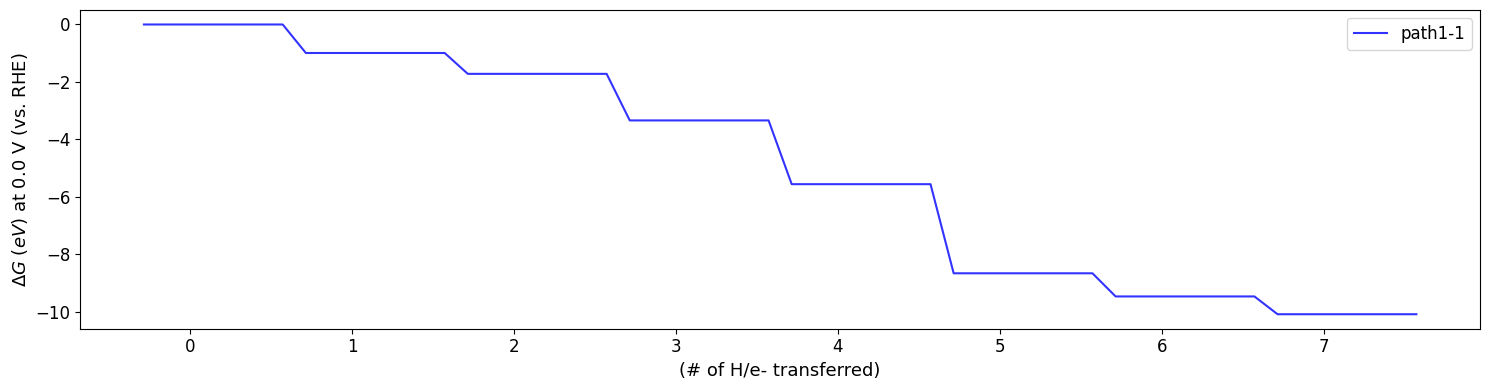

In [31]:
reactions = {#'path1': ['CH2*O', 'CH3*O', '*O+CH4', '*OH', 'H2O'],
             'path1-1': ['CO', '*CO', '*CHO', 'CH2*O', 'CH3*O', '*O+CH4', '*OH', 'H2O'],
             #'path2': ['CO', '*CO', '*CHO', '*CHOH', '*CH', '*CH2', '*CH3', 'CH4'],
             #'path3': ['CO', '*CO', '*CHO', '*CHOH', '*CH2OH', '*CH2', '*CH3', 'CH4'],
             #'path4': ['CO', '*CO', '*CHO', '*CHOH', '*CH', '*CH2', '*CH3', 'CH4'],
             #'path5': ['CO', '*CO', '*COH', '*CHOH', '*CH2OH', '*CH2', '*CH3', 'CH4'],
             #'path6': ['CO', '*CO', '*COH', '*CHOH', '*CH', '*CH2', '*CH3', 'CH4'],
             #'path7': ['CO', '*CO', '*COH', '*C', '*CH', '*CH2', '*CH3', 'CH4'],      
            }

plot_gibbs_energy_change(file_path=file_path,
                         sheet_name='C1',
                         U=0.0,
                         non_e_p_transfer_step=0,
                         color=['blue', 'red', 'green', 'black', 'purple', 'yellow', 'orange'],
                         figure_size=[15, 4],
                         reactions=reactions,
                         spanned_num=7)


In [ ]:
## $C_1$ reaction: *$COO$



============= path1 =============

----- Entered -----
 Reactant: CO2
 Product: *COO
----- Result (normal) -----
 Reaction: ['CO2', '*'] -> ['*COO']
 => Step: CO2 -> *COO
 => H_count = 1,  dG_step = -1.39799 eV

----- Entered -----
 Reactant: *COO
 Product: *COOH
----- Result (normal) -----
 Reaction: ['*COO', 'H'] -> ['*COOH']
 => Step: *COO -> *COOH
 => H_count = 1,  dG_step = -1.23384 eV

----- Entered -----
 Reactant: *COOH
 Product: *CO
----- Result (normal) -----
 Reaction: ['*COOH', 'H'] -> ['*CO', 'H2O']
 => Step: *COOH -> *CO
 => H_count = 1,  dG_step = -2.08342 eV

----- Entered -----
 Reactant: *CO
 Product: *CHO
----- Result (normal) -----
 Reaction: ['*CO', 'H'] -> ['*CHO']
 => Step: *CO -> *CHO
 => H_count = 1,  dG_step = -0.72628 eV

----- Entered -----
 Reactant: *CHO
 Product: CH2*O
----- Result (normal) -----
 Reaction: ['*CHO', 'H'] -> ['CH2*O']
 => Step: *CHO -> CH2*O
 => H_count = 1,  dG_step = -1.62061 eV

----- Entered -----
 Reactant: CH2*O
 Product: CH3*O
---

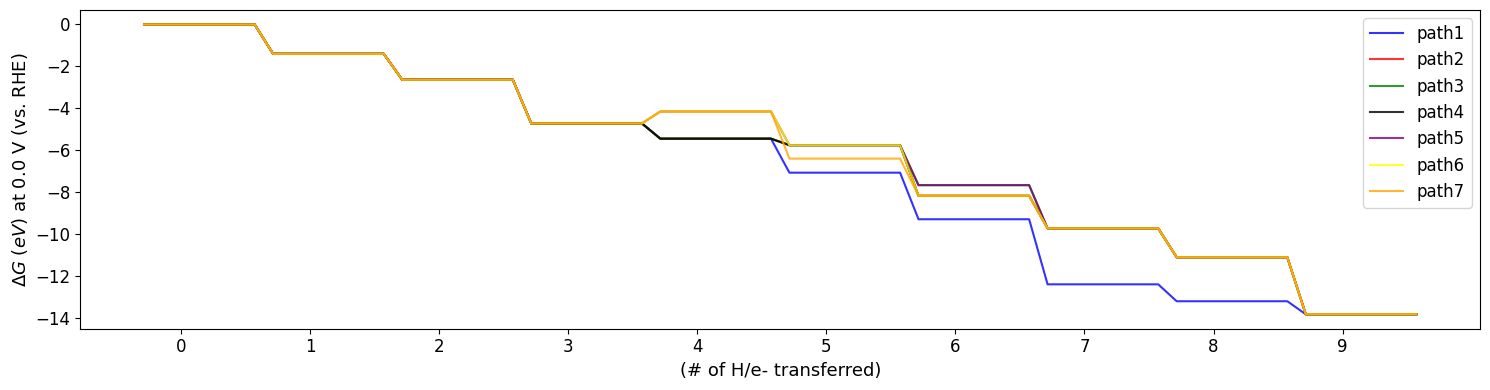

In [5]:
reactions = {'path1': ['CO2', '*COO', '*COOH', '*CO', '*CHO', 'CH2*O', 'CH3*O', '*O+CH4', '*OH', 'H2O'],
             'path2': ['CO2', '*COO', '*COOH', '*CO', '*CHO', '*CHOH', '*CH', '*CH2', '*CH3', 'CH4'],
             'path3': ['CO2', '*COO', '*COOH', '*CO', '*CHO', '*CHOH', '*CH2OH', '*CH2', '*CH3', 'CH4'],
             'path4': ['CO2', '*COO', '*COOH', '*CO', '*CHO', '*CHOH', '*CH', '*CH2', '*CH3', 'CH4'],
             'path5': ['CO2', '*COO', '*COOH', '*CO', '*COH', '*CHOH', '*CH2OH', '*CH2', '*CH3', 'CH4'],
             'path6': ['CO2', '*COO', '*COOH', '*CO', '*COH', '*CHOH', '*CH', '*CH2', '*CH3', 'CH4'],
             'path7': ['CO2', '*COO', '*COOH', '*CO', '*COH', '*C', '*CH', '*CH2', '*CH3', 'CH4'],            
            }

plot_gibbs_energy_change(file_path=file_path,
                         sheet_name='C1',
                         U=0.0,
                         non_e_p_transfer_step=0,
                         color=['blue', 'red', 'green', 'black', 'purple', 'yellow', 'orange'],
                         figure_size=[15, 4],
                         reactions=reactions,
                         spanned_num=7)


## $C_2$ reaction: *$CO$ + *$CO$



============= CO + CO =============

----- Entered -----
 Reactant: *CO-*CO
 Product: *CO*CO
----- C–C Coupling Reaction (*CO-*CO -> *CO*CO with 0H) -----
 Reaction: ['*CO-*CO'] -> ['*CO*CO']
 => Step: *CO-*CO -> *CO*CO
 => H_count = 0,  dG_step = 0.43706 eV

----- Entered -----
 Reactant: *CO*CO
 Product: *COH*CO
----- Result (normal) -----
 Reaction: ['*CO*CO', 'H'] -> ['*COH*CO']
 => Step: *CO*CO -> *COH*CO
 => H_count = 1,  dG_step = -0.94578 eV

----- Entered -----
 Reactant: *COH*CO
 Product: *CCO
----- Result (normal) -----
 Reaction: ['*COH*CO', 'H'] -> ['*CCO', 'H2O']
 => Step: *COH*CO -> *CCO
 => H_count = 1,  dG_step = -2.55731 eV

----- Entered -----
 Reactant: *CCO
 Product: *CHCO
----- Result (normal) -----
 Reaction: ['*CCO', 'H'] -> ['*CHCO']
 => Step: *CCO -> *CHCO
 => H_count = 1,  dG_step = -0.51094 eV

----- Entered -----
 Reactant: *CHCO
 Product: *CHCH*O
----- Result (normal) -----
 Reaction: ['*CHCO', 'H'] -> ['*CHCH*O']
 => Step: *CHCO -> *CHCH*O
 => H_count =

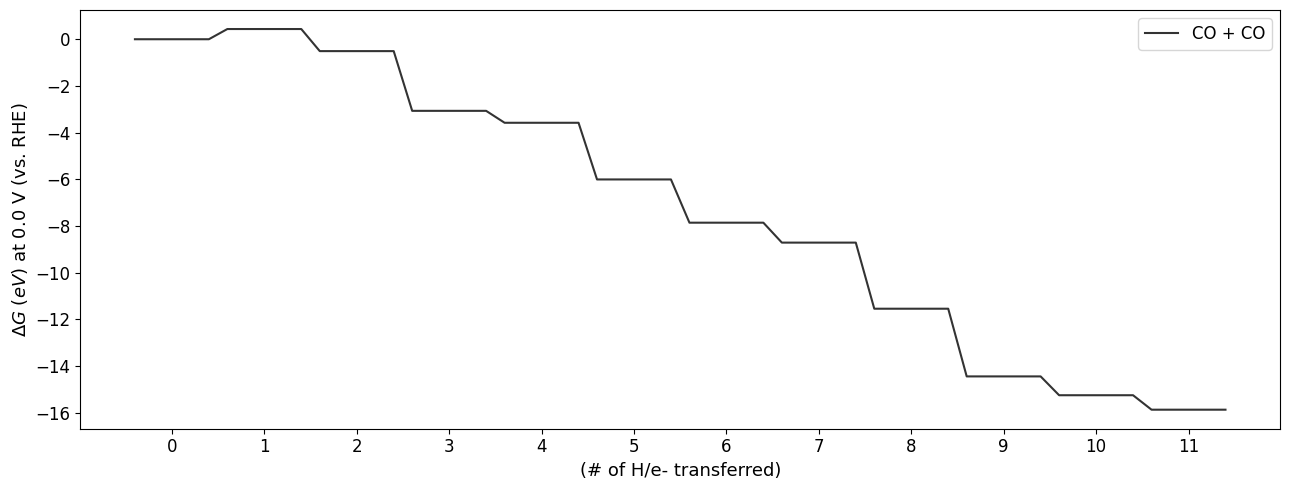

In [30]:
reactions = {'CO + CO': ['*CO-*CO', '*CO*CO', '*COH*CO', '*CCO', '*CHCO', '*CHCH*O', \
                       'CH2CH*O', 'CH3CH*O', 'CH3CH2*O', '*O+C2H6', '*OH', 'H2O']}

plot_gibbs_energy_change(file_path=file_path,
                         sheet_name='C2',
                         U=0.0,
                         non_e_p_transfer_step=0,
                         color=['black'],
                         figure_size=[13, 5],
                         reactions=reactions,
                         spanned_num=5)


## $C_2$ reaction: *$CH_2$ + *$CO$



============= CH2 + CO (5) =============

----- Entered -----
 Reactant: *CH2-*CO
 Product: *CH2*CO
----- C–C Coupling Reaction (*CH2-*CO -> *CH2*CO with 0H) -----
 Reaction: ['*CH2-*CO'] -> ['*CH2*CO']
 => Step: *CH2-*CO -> *CH2*CO
 => H_count = 0,  dG_step = -0.46604 eV

----- Entered -----
 Reactant: *CH2*CO
 Product: *COCH3
----- Result (normal) -----
 Reaction: ['*CH2*CO', 'H'] -> ['*COCH3']
 => Step: *CH2*CO -> *COCH3
 => H_count = 1,  dG_step = -1.81050 eV

----- Entered -----
 Reactant: *COCH3
 Product: CH3CH*O
----- Result (normal) -----
 Reaction: ['*COCH3', 'H'] -> ['CH3CH*O']
 => Step: *COCH3 -> CH3CH*O
 => H_count = 1,  dG_step = -0.86118 eV

----- Entered -----
 Reactant: CH3CH*O
 Product: CH3CH2*O
----- Result (normal) -----
 Reaction: ['CH3CH*O', 'H'] -> ['CH3CH2*O']
 => Step: CH3CH*O -> CH3CH2*O
 => H_count = 1,  dG_step = -2.83028 eV

----- Entered -----
 Reactant: CH3CH2*O
 Product: *O+C2H6
----- Result (normal) -----
 Reaction: ['CH3CH2*O', 'H'] -> ['*O', 'C2H6']


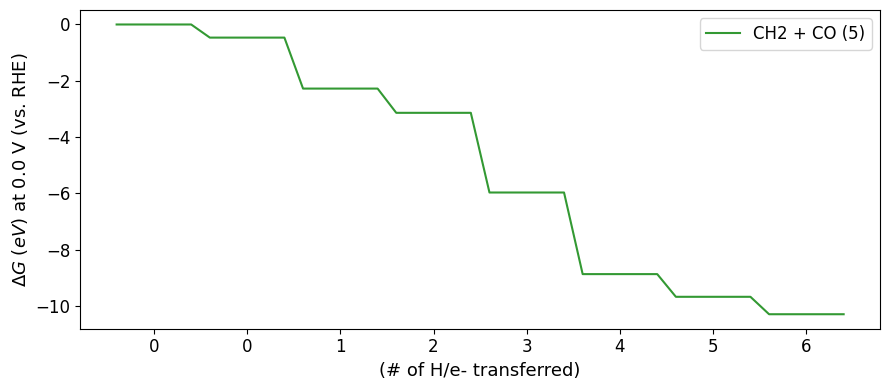

In [27]:
reactions = {#'CH2 + CO (1)': ['*CH2-*CO', 'CH2*C*O', 'CH2CH*O', 'CH3CH*O', 'CH3CH2*O', '*O+C2H6', '*OH', 'H2O'],
             #'CH2 + CO (2)': ['*CH2-*CO', 'CH2*C*O', '*COCH3', 'CH3CH*O', 'CH3CH2*O', '*O+C2H6', '*OH', 'H2O'],
             #'CH2 + CO (3)': ['*CH2-*CO', '*CH2*CO', '*CH2CHO', 'CH3CH*O', 'CH3CH2*O', '*O+C2H6', '*OH', 'H2O'],
             #'CH2 + CO (4)': ['*CH2-*CO', '*CH2*CO', '*COCH3', '*COHCH3', '*CHOHCH3', '*CHCH3', '*CH2CH3', 'C2H6'],
             'CH2 + CO (5)': ['*CH2-*CO', '*CH2*CO', '*COCH3', 'CH3CH*O', 'CH3CH2*O', '*O+C2H6', '*OH', 'H2O']}

plot_gibbs_energy_change(file_path=file_path,
                         sheet_name='C2',
                         U=0.0,
                         non_e_p_transfer_step=1,
                         color=['green', 'red', 'darkorange', 'blue', 'black'],
                         figure_size=[9, 4],
                         reactions=reactions,
                         spanned_num=5)


## $C_2$ reaction: *$CH_2$ + *$CH_2$



============= CH2 + CH2 =============

----- Entered -----
 Reactant: *CH2-*CH2
 Product: *C2H4
----- C–C Coupling Reaction (*CH2-*CH2 -> *C2H4 with 0H) -----
 Reaction: ['*CH2-*CH2'] -> ['*C2H4']
 => Step: *CH2-*CH2 -> *C2H4
 => H_count = 0,  dG_step = -0.26998 eV

----- Entered -----
 Reactant: *C2H4
 Product: *CH2CH3
----- Result (normal) -----
 Reaction: ['*C2H4', 'H'] -> ['*CH2CH3']
 => Step: *C2H4 -> *CH2CH3
 => H_count = 1,  dG_step = -1.64239 eV

----- Entered -----
 Reactant: *CH2CH3
 Product: C2H6
----- Result (normal) -----
 Reaction: ['*CH2CH3', 'H'] -> ['C2H6', '*']
 => Step: *CH2CH3 -> C2H6
 => H_count = 1,  dG_step = -2.64821 eV

 ==> Negative limiting potential = 0.00000 eV


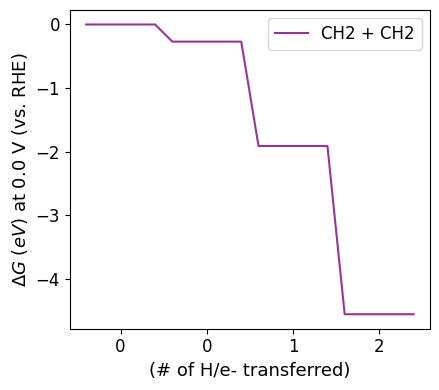

In [21]:
reactions = {'CH2 + CH2': ['*CH2-*CH2', '*C2H4', '*CH2CH3', 'C2H6']}

plot_gibbs_energy_change(file_path=file_path,
                         sheet_name='C2',
                         U=0.0,
                         non_e_p_transfer_step=1,
                         color=['purple'],
                         figure_size=[4.5, 4],
                         reactions=reactions,
                         spanned_num=5)


## $C_3$ reaction: *$CO$ insertion



============= CO insertion =============

----- Entered -----
 Reactant: *CH2CH3-*CO
 Product: *COCH2CH3
----- C–C Coupling Reaction (*CH2CH3-*CO -> *COCH2CH3 with 0H) -----
 Reaction: ['*CH2CH3-*CO'] -> ['*COCH2CH3']
 => Step: *CH2CH3-*CO -> *COCH2CH3
 => H_count = 0,  dG_step = 0.19610 eV

----- Entered -----
 Reactant: *COCH2CH3
 Product: *COHCH2CH3
----- Result (normal) -----
 Reaction: ['*COCH2CH3', 'H'] -> ['*COHCH2CH3']
 => Step: *COCH2CH3 -> *COHCH2CH3
 => H_count = 1,  dG_step = -0.15822 eV

----- Entered -----
 Reactant: *COHCH2CH3
 Product: *CHOHCH2CH3
----- Result (normal) -----
 Reaction: ['*COHCH2CH3', 'H'] -> ['*CHOHCH2CH3']
 => Step: *COHCH2CH3 -> *CHOHCH2CH3
 => H_count = 1,  dG_step = -1.77882 eV

----- Entered -----
 Reactant: *CHOHCH2CH3
 Product: *CHCH2CH3
----- Result (normal) -----
 Reaction: ['*CHOHCH2CH3', 'H'] -> ['*CHCH2CH3', 'H2O']
 => Step: *CHOHCH2CH3 -> *CHCH2CH3
 => H_count = 1,  dG_step = -1.34817 eV

----- Entered -----
 Reactant: *CHCH2CH3
 Product:

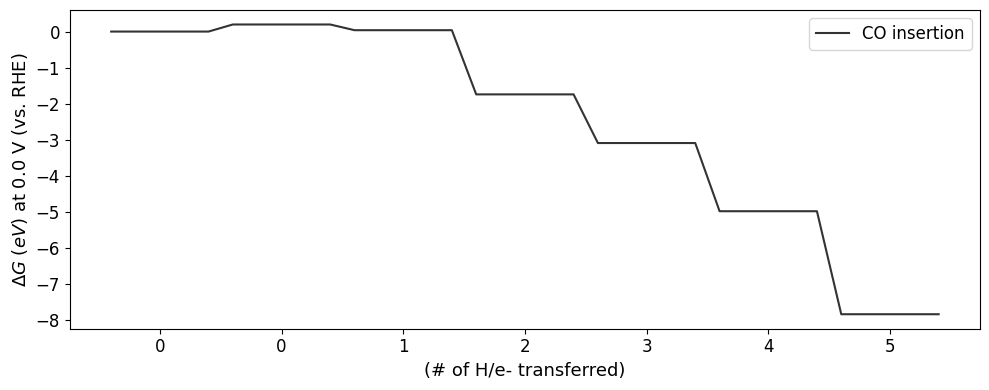

In [22]:
reactions = {'CO insertion': ['*CH2CH3-*CO', '*COCH2CH3', '*COHCH2CH3', '*CHOHCH2CH3', '*CHCH2CH3', '*CH2CH2CH3', 'C3H8']}

plot_gibbs_energy_change(file_path=file_path,
                         sheet_name='C3',
                         U=0.0,
                         non_e_p_transfer_step=1,
                         color=['black', 'red', 'blue'],
                         figure_size=[10, 4],
                         reactions=reactions,
                         spanned_num=5)


## $C_3$ reaction: *$CH_2$ insertion



============= CH2 insertion =============

----- Entered -----
 Reactant: *CH2CH3-*CH2
 Product: *CH2CH2CH3
----- C–C Coupling Reaction (*CH2CH3-*CH2 -> *CH2CH2CH3 with 0H) -----
 Reaction: ['*CH2CH3-*CH2'] -> ['*CH2CH2CH3']
 => Step: *CH2CH3-*CH2 -> *CH2CH2CH3
 => H_count = 0,  dG_step = 0.09487 eV

----- Entered -----
 Reactant: *CH2CH2CH3
 Product: C3H8
----- Result (normal) -----
 Reaction: ['*CH2CH2CH3', 'H'] -> ['C3H8', '*']
 => Step: *CH2CH2CH3 -> C3H8
 => H_count = 1,  dG_step = -2.85461 eV

 ==> Negative limiting potential = 0.09487 eV


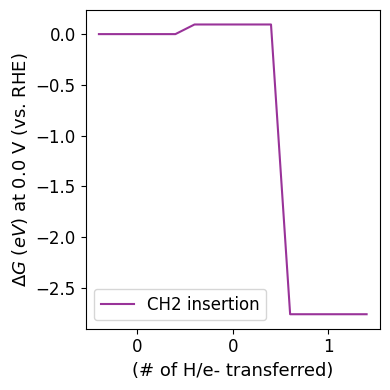

In [23]:
reactions = {'CH2 insertion': ['*CH2CH3-*CH2', '*CH2CH2CH3', 'C3H8']}

plot_gibbs_energy_change(file_path=file_path,
                         sheet_name='C3',
                         U=0.0,
                         non_e_p_transfer_step=1,
                         color=['purple'],
                         figure_size=[4, 4],
                         reactions=reactions,
                         spanned_num=5)


## $C_4$ reaction: *$CH_2$ insertion



============= CH2 insertion =============

----- Entered -----
 Reactant: *CH2CH2CH3-*CH2
 Product: *CH2(CH2)2CH3
----- C–C Coupling Reaction (*CH2CH2CH3-*CH2 -> *CH2(CH2)2CH3 with 0H) -----
 Reaction: ['*CH2CH2CH3-*CH2'] -> ['*CH2(CH2)2CH3']
 => Step: *CH2CH2CH3-*CH2 -> *CH2(CH2)2CH3
 => H_count = 0,  dG_step = 0.10710 eV

----- Entered -----
 Reactant: *CH2(CH2)2CH3
 Product: C4H10
----- Result (normal) -----
 Reaction: ['*CH2(CH2)2CH3', 'H'] -> ['C4H10', '*']
 => Step: *CH2(CH2)2CH3 -> C4H10
 => H_count = 1,  dG_step = -2.84718 eV

 ==> Negative limiting potential = 0.10710 eV


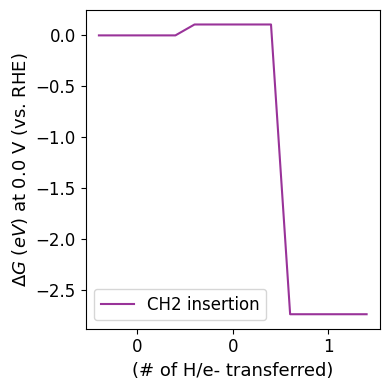

In [24]:
reactions = {'CH2 insertion': ['*CH2CH2CH3-*CH2', '*CH2(CH2)2CH3', 'C4H10']}

plot_gibbs_energy_change(file_path=file_path,
                         sheet_name='C4-C7',
                         U=0.0,
                         non_e_p_transfer_step=1,
                         color=['purple'],
                         figure_size=[4, 4],
                         reactions=reactions,
                         spanned_num=5)


## $C_5$ reaction: *$CH_2$ insertion



============= CH2 insertion =============

----- Entered -----
 Reactant: *CH2(CH2)2CH3-*CH2
 Product: *CH2(CH2)3CH3
----- C–C Coupling Reaction (*CH2(CH2)2CH3-*CH2 -> *CH2(CH2)3CH3 with 0H) -----
 Reaction: ['*CH2(CH2)2CH3-*CH2'] -> ['*CH2(CH2)3CH3']
 => Step: *CH2(CH2)2CH3-*CH2 -> *CH2(CH2)3CH3
 => H_count = 0,  dG_step = 0.05663 eV

----- Entered -----
 Reactant: *CH2(CH2)3CH3
 Product: C5H12
----- Result (normal) -----
 Reaction: ['*CH2(CH2)3CH3', 'H'] -> ['C5H12', '*']
 => Step: *CH2(CH2)3CH3 -> C5H12
 => H_count = 1,  dG_step = -2.85694 eV

 ==> Negative limiting potential = 0.05663 eV


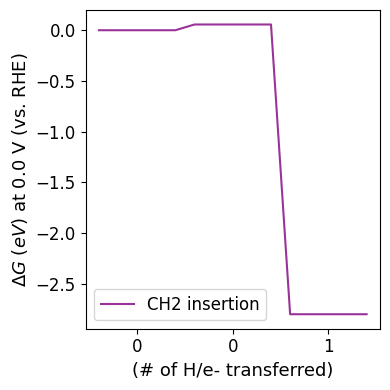

In [25]:
reactions = {'CH2 insertion': ['*CH2(CH2)2CH3-*CH2', '*CH2(CH2)3CH3', 'C5H12']}

plot_gibbs_energy_change(file_path=file_path,
                         sheet_name='C4-C7',
                         U=0.0,
                         non_e_p_transfer_step=1,
                         color=['purple'],
                         figure_size=[4, 4],
                         reactions=reactions,
                         spanned_num=5)


## $C_6$ reaction: *$CH_2$ insertion



============= CH2 insertion =============

----- Entered -----
 Reactant: *CH2(CH2)3CH3-*CH2
 Product: *CH2(CH2)4CH3
----- C–C Coupling Reaction (*CH2(CH2)3CH3-*CH2 -> *CH2(CH2)4CH3 with 0H) -----
 Reaction: ['*CH2(CH2)3CH3-*CH2'] -> ['*CH2(CH2)4CH3']
 => Step: *CH2(CH2)3CH3-*CH2 -> *CH2(CH2)4CH3
 => H_count = 0,  dG_step = 0.07928 eV

----- Entered -----
 Reactant: *CH2(CH2)4CH3
 Product: C6H14
----- Result (normal) -----
 Reaction: ['*CH2(CH2)4CH3', 'H'] -> ['C6H14', '*']
 => Step: *CH2(CH2)4CH3 -> C6H14
 => H_count = 1,  dG_step = -2.72986 eV

 ==> Negative limiting potential = 0.07928 eV


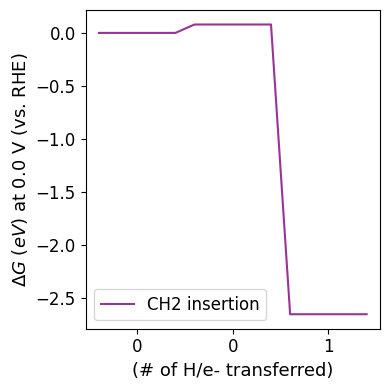

In [11]:
reactions = {'CH2 insertion': ['*CH2(CH2)3CH3-*CH2', '*CH2(CH2)4CH3', 'C6H14']}

plot_gibbs_energy_change(file_path=file_path,
                         sheet_name='C4-C7',
                         U=0.0,
                         non_e_p_transfer_step=1,
                         color=['purple'],
                         figure_size=[4, 4],
                         reactions=reactions,
                         spanned_num=5)
    

## $C_7$ reaction: *$CH_2$ insertion



============= CH2 insertion =============

----- Entered -----
 Reactant: *CH2(CH2)4CH3-*CH2
 Product: *CH2(CH2)5CH3
----- C–C Coupling Reaction (*CH2(CH2)4CH3-*CH2 -> *CH2(CH2)5CH3 with 0H) -----
 Reaction: ['*CH2(CH2)4CH3-*CH2'] -> ['*CH2(CH2)5CH3']
 => Step: *CH2(CH2)4CH3-*CH2 -> *CH2(CH2)5CH3
 => H_count = 0,  dG_step = 0.15416 eV

----- Entered -----
 Reactant: *CH2(CH2)5CH3
 Product: C7H16
----- Result (normal) -----
 Reaction: ['*CH2(CH2)5CH3', 'H'] -> ['C7H16', '*']
 => Step: *CH2(CH2)5CH3 -> C7H16
 => H_count = 1,  dG_step = -2.82110 eV

 ==> Negative limiting potential = 0.15416 eV


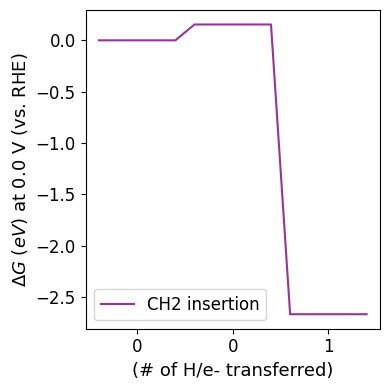

In [12]:
reactions = {'CH2 insertion': ['*CH2(CH2)4CH3-*CH2', '*CH2(CH2)5CH3', 'C7H16']}

plot_gibbs_energy_change(file_path=file_path,
                         sheet_name='C4-C7',
                         U=0.0,
                         non_e_p_transfer_step=1,
                         color=['purple'],
                         figure_size=[4, 4],
                         reactions=reactions,
                         spanned_num=5)
